# Import

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_hub as hub
import os
import datetime
from google.colab import drive
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load Data

In [ ]:
#mount gdrive
drive.mount('/content/drive')

#extract data zip
!unzip "drive/MyDrive/ifood-2019-fgvc6.zip"
!unzip "val_set.zip"
!unzip "train_set.zip"
!unzip "test_set.zip"

#ambil data file csv terlebih dahulu
label_training = pd.read_csv('train_labels.csv')
label_val = pd.read_csv('val_labels.csv')

#ambil data file txt lalu langsung convert ke dataframe
class_list = pd.read_csv('class_list.txt', sep=" ", header=None)
class_list.columns = ["id", "class"]

#buat path
path_training = ["train_set/" + id for id in label_training["img_name"]]
path_val = ["val_set/" + id for id in label_val["img_name"]]

Streaming output truncated to the last 5000 lines.
  inflating: test_set/test_007212.jpg  
  inflating: test_set/test_022242.jpg  
  inflating: test_set/test_021981.jpg  
  inflating: test_set/test_009481.jpg  
  inflating: test_set/test_013960.jpg  
  inflating: test_set/test_002362.jpg  
  inflating: test_set/test_005803.jpg  
  inflating: test_set/test_015388.jpg  
  inflating: test_set/test_002764.jpg  
  inflating: test_set/test_021964.jpg  
  inflating: test_set/test_013738.jpg  
  inflating: test_set/test_016448.jpg  
  inflating: test_set/test_022310.jpg  
  inflating: test_set/test_002203.jpg  
  inflating: test_set/test_003963.jpg  
  inflating: test_set/test_022431.jpg  
  inflating: test_set/test_003303.jpg  
  inflating: test_set/test_006227.jpg  
  inflating: test_set/test_016860.jpg  
  inflating: test_set/test_009457.jpg  
  inflating: test_set/test_020554.jpg  
  inflating: test_set/test_003655.jpg  
  inflating: test_set/test_006939.jpg  
  inflating: test_set/test_00

# Exploratory Data Analysis (EDA)

In [ ]:
print("Jumlah gambar pada train_set:", len(os.listdir("train_set/")))
print("Jumlah gambar pada val_set:", len(os.listdir("val_set/")))
print("Jumlah gambar pada test_set:", len(os.listdir("test_set/")))

Jumlah gambar pada train_set: 118475
Jumlah gambar pada val_set: 11994
Jumlah gambar pada test_set: 28377


In [ ]:
label_training.head()

,img_name,label
0,train_101733.jpg,211
1,train_101734.jpg,211
2,train_101735.jpg,211
3,train_101736.jpg,211
4,train_101737.jpg,211


In [ ]:
label_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118475 entries, 0 to 118474
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   img_name  118475 non-null  object
 1   label     118475 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [ ]:
label_training["label"].value_counts()

218    656
147    636
155    635
0      633
117    617
      ... 
103    300
83     290
164    289
213    277
162     34
Name: label, Length: 251, dtype: int64

In [ ]:
label_val.head()

,img_name,label
0,val_010323.jpg,247
1,val_010324.jpg,234
2,val_010325.jpg,222
3,val_010326.jpg,240
4,val_010327.jpg,218


In [ ]:
label_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11994 entries, 0 to 11993
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_name  11994 non-null  object
 1   label     11994 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.5+ KB


In [ ]:
label_val["label"].value_counts()

201    69
34     67
168    65
119    64
160    64
       ..
99     21
239    17
238    11
189     9
116     2
Name: label, Length: 251, dtype: int64

In [ ]:
class_list.head()

,id,class
0,0,macaron
1,1,beignet
2,2,cruller
3,3,cockle_food
4,4,samosa


In [ ]:
class_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      251 non-null    int64 
 1   class   251 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [ ]:
path_training[:5]

['train_set/train_101733.jpg',
 'train_set/train_101734.jpg',
 'train_set/train_101735.jpg',
 'train_set/train_101736.jpg',
 'train_set/train_101737.jpg']

In [ ]:
len(path_training)

118475

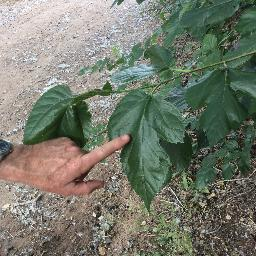

In [ ]:
#menampilkan contoh gambar pada path_training
Image(path_training[0])

In [ ]:
path_val[:5]

['val_set/val_010323.jpg',
 'val_set/val_010324.jpg',
 'val_set/val_010325.jpg',
 'val_set/val_010326.jpg',
 'val_set/val_010327.jpg']

In [ ]:
len(path_val)

11994

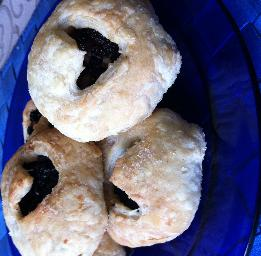

In [ ]:
#menampilkan contoh gambar pada path_val
Image(path_val[0])

# Check Version & GPU

In [ ]:
print("TF yang digunakan versi:",tf.__version__)
print("HUB yang digunakan versi:",hub.__version__)
print("Cek GPU:","GPU tersedia" if tf.config.list_physical_devices("GPU") else "GPU tidak tersedia")

TF yang digunakan versi: 2.8.0
HUB yang digunakan versi: 0.12.0
Cek GPU: GPU tersedia


# Preprocessing

**Data Preprocessing**

In [ ]:
#buat dataframe 'label_training_fix'
label_training2 = label_training.rename(columns={'img_name': 'img_name', 'label': 'id'})
label_training_fix = pd.merge(label_training2, class_list, on="id", how="inner")
label_training_fix.rename(columns={'class': 'label'}, inplace=True)
label_training_fix.drop(['id'], axis=1, inplace=True)
#conversikan kolom "label" pada dataframe "label_training_fix" menjadi numpy array
label_training_array = label_training_fix["label"].to_numpy()
#buat variable untuk menampung unique label dari "label_training_array"
unique_label_training = np.unique(label_training_array)
#ubah semua data array label pada 'label_training_array' menjadi boolean
boolean_label_training = [i == np.array(unique_label_training) for i in label_training_array]

#buat dataframe 'label_val_fix'
label_val2 = label_val.rename(columns={'img_name': 'img_name', 'label': 'id'})
label_val_fix = pd.merge(label_val2, class_list, on="id", how="inner")
label_val_fix.rename(columns={'class': 'label'}, inplace=True)
label_val_fix.drop(['id'], axis=1, inplace=True)
#conversikan kolom "label" pada dataframe "label_val_fix" menjadi numpy array
label_val_array = label_val_fix["label"].to_numpy()
#buat variable untuk menampung unique label dari "label_val_array"
unique_label_val = np.unique(label_val_array)
#ubah semua data array label pada 'label_val_array' menjadi boolean
boolean_label_val = [i == np.array(unique_label_val) for i in label_val_array]

#Cek apakah jumlah unique label sama antara data training dan data valid
print("Jumlah unique label pada data training:", len(unique_label_training))
print("Jumlah unique label pada data valid:", len(unique_label_val))

Jumlah unique label pada data training: 251
Jumlah unique label pada data valid: 251


**Kesimpulannya: Jumlah unique label antara training dan valid sama, maka kedua dataset tersebut dapat digunakan untuk training model.**

**Image Preprocessing**

In [ ]:
#buat variable untuk mendefinisikan besarnya gambar
img_size = 384

#buat function
def image_preprocessing(image_path):
  #buka gambar
  image = tf.io.read_file(image_path)
  #ubah gambar menjadi tensor numeric dengan 3 warna channel (merah, hijau, biru)
  image = tf.image.decode_jpeg(image, channels=3)
  #konversi warna channel dari 0-225 menjadi 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  #ubah ukuran gambar sesuai dengan variable yang telah dibuat di atas
  image = tf.image.resize(image, size=[img_size, img_size])
  return image

In [ ]:
def load_image_label(image_path, label):
  image = image_preprocessing(image_path)
  return image, label

In [ ]:
#buat variable untuk mendefinisikan besarnya batch
size = 32 #besarnya batch yang direkomedasikan adalah 32/64 -> https://www.sciencedirect.com/science/article/pii/S2405959519303455#:~:text=In%20practical%20terms%2C%20to%20determine,advantage%20of%20the%20GPUs%20processing.

def create_batch(x, y=None, batch_size=size, valid_data=False, test_data=False):
  #jika datanya adalah data testing, maka kita buat agar tidak memiliki label
  if test_data:
    print("Sedang membuat batch data testing...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) #hanya filepath
    data_batch = data.map(image_preprocessing).batch(size)
    return data_batch
  
  #jika datanya adalah data untuk validasi, maka kita tidak perlu mengacaknya
  elif valid_data:
    print("Sedang membuat batch data untuk validasi...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y))) # x=filepath dan y=label
    data_batch = data.map(load_image_label).batch(size)
    return data_batch
  
  #jika datanya adalah data training, maka kita perlu mengacaknya
  else:
    print("sedang membuat batch data untuk training...")
    #kembalikan filepath dan label menjadi tensor
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y))) # x=filepath dan y=label
    #acak
    data = data.shuffle(buffer_size=len(x))
    #buat gambar dan label kembali ke path untuk di preprocessing
    data = data.map(load_image_label)
    #kembalikan data kedalam batch
    data_batch = data.batch(size)
  
  return data_batch

**Visualitation from Image Preprocessing**

In [ ]:
#untuk visualisasi kita buat function agar menjadi lebih mudah
def display_images(images, labels):
  #buat figure
  plt.figure(figsize=(10, 10))
  #buat looping untuk menampilkan gambar
  for i in range(10):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_label_training[labels[i].argmax()])
    plt.axis("off")

# Modelling

## Create Function

**Function for Create Model**

In [ ]:
#atur input shape ke dalam model
INPUT_SHAPE = [None, img_size, img_size, 3]
#atur output shape untuk model
OUTPUT_SHAPE = len(unique_label_training)
#atur model dari URL TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2"

#buat function
def new_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Membuat model dengan:", MODEL_URL)
  #atur model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 2 (output layer)
  ])

  #compile model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), #untuk mengurangi kesalahan klasifikasi pada model
      optimizer=tf.keras.optimizers.Adam(), #untuk meningkatkan klasifikasi pada model
      metrics=["accuracy"] #untuk membandingkan perbedaan peningkatan
  )

  #buat model
  model.build(INPUT_SHAPE) #membuat model dengan memasukan inputan didalamnya
  
  return model

**Function for Create Callback**

In [ ]:
%load_ext tensorboard

#buat function untuk TensorBoard callback
def create_tensorboard_callback():
  #buat TensorBoard logs
  logdir = os.path.join("drive/My Drive/Data/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
#buat early stopping callback (tujuannya agar model berhenti untuk improving dan stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3) #otomatis stop setelah tanpa improvements 3kali

**Function for Train Model**

In [ ]:
#berapa putaran yang harus kita dapatkan agar model dapat melihat data?
NUM_EPOCHS = 4

#buat function untuk melatih model
def training_model():
  #buat model
  model = new_model()

  #buat tensorboard session baru setiap kali kita melatih model
  tensorboard = create_tensorboard_callback()

  #fit model
  model.fit(x=train, epochs=NUM_EPOCHS, validation_data=val,
            validation_freq=1, #cek matrix validasi disetiap epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

## Run Model

**Split Data**

In [ ]:
X_train = path_training
y_train = boolean_label_training
X_val = path_val
y_val = boolean_label_val

#display xtrain dll
len(X_train), len(y_train), len(X_val), len(y_val)

(118475, 118475, 11994, 11994)

**Run Image Preprocessing**

In [ ]:
#tes function yang telah dibuat
train = create_batch(X_train, y_train)
val = create_batch(X_val, y_val, valid_data=True)

#cek apakah terdapat perbedaan antara data training dan data untuk validasi
train.element_spec, val.element_spec

sedang membuat batch data untuk training...
Sedang membuat batch data untuk validasi...


((TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 251), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 251), dtype=tf.bool, name=None)))

**Run Visualitation from Image Preprocessing**

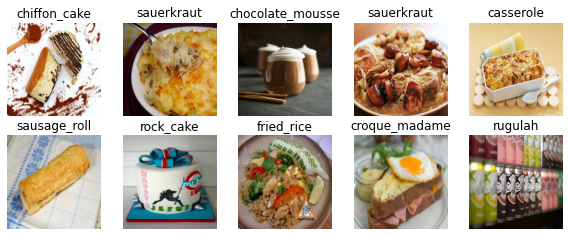

In [ ]:
#tes function untuk menampilkan gambar data training
train_images, train_labels = next(train.as_numpy_iterator())
display_images(train_images, train_labels)

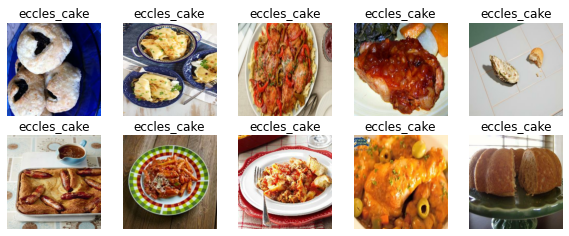

In [ ]:
#tes function untuk menampilkan data valid
val_images, val_labels = next(val.as_numpy_iterator())
display_images(val_images, val_labels)

**Run Create Model**

In [ ]:
#tes function di atas
model = new_model()
model.summary()

Membuat model dengan: https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dense (Dense)               (None, 251)               321531    
                                                                 
Total params: 20,652,891
Trainable params: 321,531
Non-trainable params: 20,331,360
_________________________________________________________________


**Run Train Model**

In [ ]:
#tes function
model = training_model()

Membuat model dengan: https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2
Epoch 1/4
3703/3703 [==============================] - 1294s 343ms/step - loss: 2.1765 - accuracy: 0.5167 - val_loss: 11.9824 - val_accuracy: 0.0064
Epoch 2/4
3703/3703 [==============================] - 1301s 351ms/step - loss: 1.5570 - accuracy: 0.6276 - val_loss: 12.8546 - val_accuracy: 0.0068
Epoch 3/4
3703/3703 [==============================] - 1305s 352ms/step - loss: 1.3362 - accuracy: 0.6711 - val_loss: 13.6189 - val_accuracy: 0.0063
Epoch 4/4
3703/3703 [==============================] - 1305s 352ms/step - loss: 1.1892 - accuracy: 0.6990 - val_loss: 14.2587 - val_accuracy: 0.0068


**Check Log Tensorboard**

In [ ]:
%tensorboard --logdir drive/My\ Drive/Data/logs

UsageError: Line magic function `%tensorboard` not found.


# Save & load model

In [ ]:
def save_model(model, suffix=None):
  # Create model directory with current time
  modeldir = os.path.join("drive/My Drive/Data/",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  print(f"Loading saved model dari: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
#simpan model ke gdrive
save_model(model_images, suffix="efficientnet_v2_imagenet21k_ft1k_s-tune2")

Saving model to: drive/My Drive/Data/20220302-08131646208824-efficientnet_v2_imagenet21k_ft1k_s-tune2.h5...


'drive/My Drive/Data/20220302-08131646208824-efficientnet_v2_imagenet21k_ft1k_s-tune2.h5'

In [ ]:
#load model dari gdrive
model_images = load_model('drive/My Drive/Data/efficientnet_v2_imagenet21k_ft1k_s.h5')

Loading saved model dari: drive/My Drive/Data/efficientnet_v2_imagenet21k_ft1k_s.h5


# Test predictions with test_set

In [ ]:
test_path = "test_set/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['test_set/test_005211.jpg',
 'test_set/test_002150.jpg',
 'test_set/test_007922.jpg',
 'test_set/test_002946.jpg',
 'test_set/test_020921.jpg',
 'test_set/test_025085.jpg',
 'test_set/test_010869.jpg',
 'test_set/test_022193.jpg',
 'test_set/test_013999.jpg',
 'test_set/test_001673.jpg']

In [ ]:
len(test_filenames)

28377

In [ ]:
test_data = create_batch(test_filenames, test_data=True)

Sedang membuat batch data testing...


In [ ]:
test_predictions = model_images.predict(test_data, verbose=1)

887/887 [==============================] - 268s 301ms/step


In [ ]:
len(test_predictions)

28377

In [ ]:
test_predictions.shape

(28377, 251)

In [ ]:
#Prediksi pertama
print(test_predictions[0])
print(f"Nilai max (probabilitas prediksi): {np.max(test_predictions[0])}") #nilai max dari probabilitas prediksi saat menggunakan model
print(f"Column label: {np.argmax(test_predictions[0])}") #mengambil prediksi terbaik ada di kolom apa
print(f"Prediksi label: {unique_label_training[np.argmax(test_predictions[0])]}") #convert kolom dengan prediksi terbaik ke nama labelnya

[9.93086502e-10 1.59177404e-07 2.92340130e-09 1.67730774e-10
 3.96739558e-10 6.80265176e-12 1.00763200e-11 1.14733423e-09
 1.21991878e-11 3.84585835e-11 1.21212007e-09 3.15161147e-10
 1.64462097e-10 6.13656570e-10 3.18767457e-09 5.90692717e-10
 4.81771810e-11 1.53164468e-08 2.38906828e-11 1.43868411e-13
 2.76021029e-11 3.94776052e-11 6.59333135e-12 2.32068559e-10
 9.67210131e-11 2.85239810e-09 8.70095662e-12 3.17065207e-10
 2.76462186e-10 6.78971506e-12 2.74752820e-09 2.39106152e-10
 3.99572986e-10 3.16587379e-09 6.23854888e-08 5.66932856e-09
 3.47414155e-13 3.27072875e-08 5.04661957e-09 7.86219700e-10
 1.56102562e-08 2.79240051e-11 2.95739024e-11 4.69840948e-08
 4.10490031e-07 7.20708648e-09 5.35774420e-12 1.10133816e-14
 2.36326914e-09 5.97828384e-12 2.84848317e-13 1.77565385e-09
 4.87575362e-11 9.57150938e-12 1.08196909e-05 9.97544706e-01
 6.10665185e-10 1.50884036e-03 6.06850860e-14 5.28245503e-11
 1.39783046e-11 3.97413267e-08 5.57345814e-08 1.00872439e-05
 4.42951995e-11 8.571369

In [ ]:
#ubah probabilitas prediksi menjadi label masing-masing (agar lebih mudah dipahami)
def prediction_label(prediction_probabilities):
  return unique_label_training[np.argmax(prediction_probabilities)]

#ambil prediksi label dari array probabilitas prediksi
pred_label = prediction_label(test_predictions[0])
print("Label prediksinya: ", pred_label)

Label prediksinya:  clam_food


In [ ]:
labels = []
for i in range(len(test_predictions)):
  labels.append(prediction_label(test_predictions[i]))

In [ ]:
labels

['clam_food',
 'sauerkraut',
 'french_toast',
 'barbecued_spareribs',
 'couscous',
 'egg_roll',
 'scrambled_eggs',
 'french_toast',
 'haggis',
 'knish',
 'cupcake',
 'spaghetti_carbonara',
 'jerky',
 'ramen',
 'hamburger',
 'huevos_rancheros',
 'ziti',
 'eggs_benedict',
 'osso_buco',
 'gyoza',
 'pound_cake',
 'sauerkraut',
 'chicken_quesadilla',
 'penne',
 'cannelloni',
 'prime_rib',
 'dumpling',
 'peach_melba',
 'boiled_egg',
 'pho',
 'eggs_benedict',
 'shrimp_and_grits',
 'egg_roll',
 'casserole',
 'crumb_cake',
 'fried_calamari',
 'fondue',
 'fritter',
 'taco',
 'baby_back_rib',
 'clam_food',
 'stuffed_peppers',
 'chicken_cordon_bleu',
 'pepper_steak',
 'pad_thai',
 'cupcake',
 'casserole',
 'crab_food',
 'victoria_sandwich',
 'haggis',
 'galantine',
 'beef_wellington',
 'deviled_egg',
 'beef_tartare',
 'tamale',
 'lobster_roll_sandwich',
 'pork_chop',
 'boston_cream_pie',
 'osso_buco',
 'beef_wellington',
 'cannelloni',
 'ham_and_eggs',
 'chocolate_cake',
 'baked_alaska',
 'scallop

**Create for Submission**

In [ ]:
preds_df = pd.DataFrame(columns=["img_name", "label"])
preds_df["img_name"] = [os.path.splitext(path)[0] + ".jpg" for path in os.listdir(test_path)]
preds_df["label"] = labels
preds_df.head()

,img_name,label
0,test_005211.jpg,clam_food
1,test_002150.jpg,sauerkraut
2,test_007922.jpg,french_toast
3,test_002946.jpg,barbecued_spareribs
4,test_020921.jpg,couscous


In [ ]:
preds_df2 = preds_df.rename(columns={'img_name': 'img_name', 'label': 'class'})
submission = pd.merge(preds_df2, class_list, on="class", how="inner")
submission.rename(columns={'id': 'label'}, inplace=True)
submission.drop(['class'], axis=1, inplace=True)
submission.sort_values(by=['img_name'], inplace=True)

In [ ]:
submission

,img_name,label
3892,test_000000.jpg,147
25859,test_000001.jpg,71
27786,test_000002.jpg,88
11298,test_000003.jpg,232
18292,test_000004.jpg,106
...,...,...
21711,test_028394.jpg,220
11279,test_028395.jpg,232
1187,test_028396.jpg,10
24922,test_028397.jpg,244


In [ ]:
submission.to_csv("drive/My Drive/Data/efficientnet_v2_imagenet21k_ft1k_s.csv", index=False)
submission.to_csv("efficientnet_v2_imagenet21k_ft1k_s.csv", index=False)

# Predict with Import Image

Sedang membuat batch data testing...


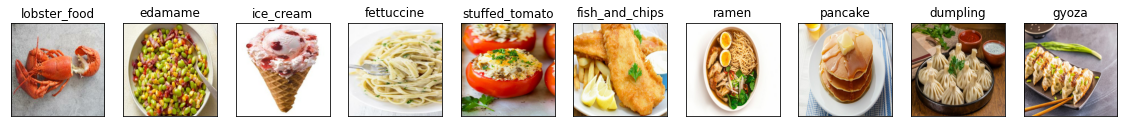

In [ ]:
custom_path = "drive/MyDrive/Data/custom/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_data = create_batch(custom_image_paths, test_data=True)
custom_preds = model_images.predict(custom_data)

custom_pred_labels = [prediction_label(custom_preds[i]) for i in range(len(custom_preds))]

custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

plt.figure(figsize=(40, 20))
for i, image in enumerate(custom_images):
  plt.subplot(1, 20, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)